In [3]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
import math
from scipy.stats import kendalltau

import timeit #准确测量小段代码的执行时间

import warnings
warnings.filterwarnings('ignore')

In [4]:
# loading dataset
kills = pd.read_csv('./dataSets/kills.csv')
matchinfo = pd.read_csv('./dataSets/matchinfo.csv')
monsters = pd.read_csv('./dataSets/monsters.csv')
structures = pd.read_csv('./dataSets/structures.csv')

In [16]:
matchinfo

,League,Year,Season,Type,blueTeamTag,bResult,rResult,redTeamTag,gamelength,blueTop,...,redJungle,redJungleChamp,redMiddle,redMiddleChamp,redADC,redADCChamp,redSupport,redSupportChamp,Address,id
0,NALCS,2015,Spring,Season,TSM,1,0,C9,40,Dyrus,...,Meteos,Elise,Hai,Fizz,Sneaky,Sivir,LemonNation,Thresh,http://matchhistory.na.leagueoflegends.com/en/...,fbb300951ad8327c
1,NALCS,2015,Spring,Season,CST,0,1,DIG,38,Cris,...,Crumbzz,JarvanIV,Shiphtur,Azir,CoreJJ,Corki,KiWiKiD,Annie,http://matchhistory.na.leagueoflegends.com/en/...,055b17da8456fdc8
2,NALCS,2015,Spring,Season,WFX,1,0,GV,40,Flaresz,...,Saintvicious,LeeSin,Keane,Azir,Cop,Corki,BunnyFuFuu,Janna,http://matchhistory.na.leagueoflegends.com/en/...,8e8a9b58df366e2d
3,NALCS,2015,Spring,Season,TIP,0,1,TL,41,Rhux,...,IWDominate,Nunu,Fenix,Lulu,KEITH,KogMaw,Xpecial,Janna,http://matchhistory.na.leagueoflegends.com/en/...,0ed1cd0e0e57329c
4,NALCS,2015,Spring,Season,CLG,1,0,T8,35,Benny,...,Porpoise8,RekSai,Slooshi8,Lulu,Maplestreet8,Corki,Dodo8,Annie,http://matchhistory.na.leagueoflegends.com/en/...,f932becf86175f38
5,NALCS,2015,Spring,Season,DIG,0,1,TIP,24,Gamsu,...,Rush,JarvanIV,XiaoWeiXiao,Lulu,Apollo,Corki,Adrian,Thresh,http://matchhistory.na.leagueoflegends.com/en/...,194c672d7969984f
6,NALCS,2015,Spring,Season,CST,1,0,WFX,39,Cris,...,ShorterACE,LeeSin,Pobelter,Leblanc,Altec,Tristana,Gleeb,Nami,http://matchhistory.na.leagueoflegends.com/en/...,2a7ecaf7380e9d89
7,NALCS,2015,Spring,Season,TL,1,0,CLG,43,Quas,...,Xmithie,Rengar,Link,Leblanc,Doublelift,Sivir,Aphromoo,Blitzcrank,http://matchhistory.na.leagueoflegends.com/en/...,c1678fe8c1106f56
8,NALCS,2015,Spring,Season,C9,0,1,GV,41,Balls,...,Saintvicious,Vi,Keane,Zed,Cop,Corki,Bunny FuFuu,Morgana,http://matchhistory.na.leagueoflegends.com/en/...,23bade11cbfc3da3
9,NALCS,2015,Spring,Season,T8,1,0,TSM,32,CaliTrlolz8,...,Santorin,Rengar,Bjergsen,Leblanc,WildTurtle,Graves,Lustboy,Morgana,http://matchhistory.na.leagueoflegends.com/en/...,bb82a23d050613d1


In [20]:
# 为每行数据添加ID
matchinfo['id'] = matchinfo['Address'].astype(str).str[-16:]
kills['id'] = kills['Address'].astype(str).str[-16:]
monsters['id'] = monsters['Address'].astype(str).str[-16:]
structures['id'] = structures['Address'].astype(str).str[-16:]
monsters.head()

,Address,Team,Time,Type,id
696,http://matchhistory.na.leagueoflegends.com/en/...,bDragons,23.444,EARTH_DRAGON,55109b5a7a91ae87
697,http://matchhistory.na.leagueoflegends.com/en/...,bDragons,31.069,WATER_DRAGON,55109b5a7a91ae87
698,http://matchhistory.na.leagueoflegends.com/en/...,bDragons,16.419,AIR_DRAGON,55109b5a7a91ae87
699,http://matchhistory.na.leagueoflegends.com/en/...,bDragons,32.022,EARTH_DRAGON,e147296c928da5b4
700,http://matchhistory.na.leagueoflegends.com/en/...,bDragons,25.304,WATER_DRAGON,e147296c928da5b4


In [18]:
# Dragon became multiple types in patch v6.9 (http://leagueoflegends.wikia.com/wiki/V6.9) 
# so we remove and games before this change occured and only use games with the new dragon system
monsters['Type'].unique()

old_dragon_id = monsters[ monsters['Type']=="DRAGON"]['id'].unique()
old_dragon_id

array(['fbb300951ad8327c', '055b17da8456fdc8', '8e8a9b58df366e2d', ...,
       'd2eaf13bcbb3c021', '035394afd3bfc218', '94537494cdbc8b4c'], dtype=object)

In [19]:
monsters = monsters[ ~monsters['id'].isin(old_dragon_id)]
monsters[monsters['Type']=="DRAGON"]

,Address,Team,Time,Type,id


In [22]:
# Again remove old games, we have some missing values (probably for other events) so remove this
# Create a column for the minute in which the kill took place
# Reassign the team column to a simpler Red/Blue accordingly for matching with other tables

kills = kills[ ~kills['id'].isin(old_dragon_id)]
kills = kills[ kills['Time']>0]

kills['Minute'] = kills['Time'].astype(int)

kills['Team'] = np.where( kills['Team']=="rKills","Red","Blue")
kills.head()

,Address,Team,Time,Victim,Killer,Assist_1,Assist_2,Assist_3,Assist_4,x_pos,y_pos,id,Minute
4462,http://matchhistory.na.leagueoflegends.com/en/...,Blue,6.032,CLG Huhi,TSM Svenskeren,TSM Bjergsen,NaN,NaN,NaN,7825,8666,55109b5a7a91ae87,6
4463,http://matchhistory.na.leagueoflegends.com/en/...,Blue,9.428,CLG Huhi,TSM Biofrost,TSM Bjergsen,TSM Doublelift,NaN,NaN,8728,8751,55109b5a7a91ae87,9
4464,http://matchhistory.na.leagueoflegends.com/en/...,Blue,9.780,CLG Xmithie,TSM Bjergsen,TSM Hauntzer,TSM Svenskeren,NaN,NaN,8655,1172,55109b5a7a91ae87,9
4465,http://matchhistory.na.leagueoflegends.com/en/...,Blue,10.252,CLG Stixxay,TSM Doublelift,TSM Biofrost,NaN,NaN,NaN,3621,11607,55109b5a7a91ae87,10
4466,http://matchhistory.na.leagueoflegends.com/en/...,Blue,12.993,CLG Darshan,TSM Doublelift,TSM Biofrost,NaN,NaN,NaN,5674,12903,55109b5a7a91ae87,12


In [23]:
# For the Kills table, we need decided to group by the minute in which the kills took place and averaged 
# the time of the kills which we use later for the order of events
f = {'Time':['mean','count']}
killsGrouped = kills.groupby( ['id','Team','Minute'] ).agg(f).reset_index()
killsGrouped.columns = ['id','Team','Minute','Time Avg','Count']
killsGrouped = killsGrouped.sort_values(by=['id','Minute'])
killsGrouped.head(13)

,id,Team,Minute,Time Avg,Count
4,0001f4374a03c133,Red,4,4.6350,1
5,0001f4374a03c133,Red,6,6.0640,1
0,0001f4374a03c133,Blue,8,8.1940,1
6,0001f4374a03c133,Red,10,10.4780,1
7,0001f4374a03c133,Red,17,17.3870,2
1,0001f4374a03c133,Blue,18,18.0980,1
8,0001f4374a03c133,Red,18,18.0670,2
9,0001f4374a03c133,Red,21,21.7900,1
2,0001f4374a03c133,Blue,22,22.5125,2
10,0001f4374a03c133,Red,22,22.4578,5


In [24]:
# Repeat similar steps for the structures table

structures = structures[ ~structures['id'].isin(old_dragon_id)]
structures = structures[ structures['Time']>0]

structures['Minute'] = structures['Time'].astype(int)
structures['Team'] = np.where(structures['Team']=="bTowers","Blue",
                        np.where(structures['Team']=="binhibs","Blue","Red"))
structures2 = structures.sort_values(by=['id','Minute'])
structures2.head(13)

,Address,Team,Time,Lane,Type,id,Minute
6740,http://matchhistory.na.leagueoflegends.com/en/...,Blue,11.182,TOP_LANE,OUTER_TURRET,0001f4374a03c133,11
57600,http://matchhistory.na.leagueoflegends.com/en/...,Red,11.006,BOT_LANE,OUTER_TURRET,0001f4374a03c133,11
6741,http://matchhistory.na.leagueoflegends.com/en/...,Blue,16.556,BOT_LANE,OUTER_TURRET,0001f4374a03c133,16
57601,http://matchhistory.na.leagueoflegends.com/en/...,Red,16.145,TOP_LANE,OUTER_TURRET,0001f4374a03c133,16
57598,http://matchhistory.na.leagueoflegends.com/en/...,Red,18.378,MID_LANE,OUTER_TURRET,0001f4374a03c133,18
57602,http://matchhistory.na.leagueoflegends.com/en/...,Red,24.943,MID_LANE,INNER_TURRET,0001f4374a03c133,24
57599,http://matchhistory.na.leagueoflegends.com/en/...,Red,25.463,TOP_LANE,INNER_TURRET,0001f4374a03c133,25
57597,http://matchhistory.na.leagueoflegends.com/en/...,Red,26.330,BOT_LANE,INNER_TURRET,0001f4374a03c133,26
57594,http://matchhistory.na.leagueoflegends.com/en/...,Red,33.153,MID_LANE,BASE_TURRET,0001f4374a03c133,33
57595,http://matchhistory.na.leagueoflegends.com/en/...,Red,33.326,MID_LANE,NEXUS_TURRET,0001f4374a03c133,33


In [25]:
# Merge the two together
kills_structures = killsGrouped.merge(structures2[['id','Minute','Team','Time','Lane','Type']],
                                      on=['id','Minute','Team'],how='outer')
kills_structures.head(20)

,id,Team,Minute,Time Avg,Count,Time,Lane,Type
0,0001f4374a03c133,Red,4,4.6350,1.0,NaN,NaN,NaN
1,0001f4374a03c133,Red,6,6.0640,1.0,NaN,NaN,NaN
2,0001f4374a03c133,Blue,8,8.1940,1.0,NaN,NaN,NaN
3,0001f4374a03c133,Red,10,10.4780,1.0,NaN,NaN,NaN
4,0001f4374a03c133,Red,17,17.3870,2.0,NaN,NaN,NaN
5,0001f4374a03c133,Blue,18,18.0980,1.0,NaN,NaN,NaN
6,0001f4374a03c133,Red,18,18.0670,2.0,18.378,MID_LANE,OUTER_TURRET
7,0001f4374a03c133,Red,21,21.7900,1.0,NaN,NaN,NaN
8,0001f4374a03c133,Blue,22,22.5125,2.0,NaN,NaN,NaN
9,0001f4374a03c133,Red,22,22.4578,5.0,NaN,NaN,NaN


In [26]:
# Again repeat same steps, we also map the types of dragon to a simpler 'Dragon' label

monsters = monsters[ ~monsters['id'].isin(old_dragon_id)]
monsters['Type2'] = np.where( monsters['Type']=="FIRE_DRAGON", "DRAGON",
                    np.where( monsters['Type']=="EARTH_DRAGON","DRAGON",
                    np.where( monsters['Type']=="WATER_DRAGON","DRAGON",       
                    np.where( monsters['Type']=="AIR_DRAGON","DRAGON",   
                             monsters['Type']))))

monsters = monsters[ monsters['Time']>0]

monsters['Minute'] = monsters['Time'].astype(int)

monsters['Team'] = np.where( monsters['Team']=="bDragons","Blue",
                   np.where( monsters['Team']=="bHeralds","Blue",
                   np.where( monsters['Team']=="bBarons", "Blue", 
                           "Red")))



monsters.head()

,Address,Team,Time,Type,id,Type2,Minute
696,http://matchhistory.na.leagueoflegends.com/en/...,Blue,23.444,EARTH_DRAGON,55109b5a7a91ae87,DRAGON,23
697,http://matchhistory.na.leagueoflegends.com/en/...,Blue,31.069,WATER_DRAGON,55109b5a7a91ae87,DRAGON,31
698,http://matchhistory.na.leagueoflegends.com/en/...,Blue,16.419,AIR_DRAGON,55109b5a7a91ae87,DRAGON,16
699,http://matchhistory.na.leagueoflegends.com/en/...,Blue,32.022,EARTH_DRAGON,e147296c928da5b4,DRAGON,32
700,http://matchhistory.na.leagueoflegends.com/en/...,Blue,25.304,WATER_DRAGON,e147296c928da5b4,DRAGON,25


In [27]:
# Merge the monsters to our previously merged table
# This provides us with a table that has each event seperated by columns depending on what type of event it was
kills_structures_monsters = kills_structures.merge(monsters[['id','Minute','Team','Time','Type2']], on=['id','Minute'],how='outer')
kills_structures_monsters = kills_structures_monsters.sort_values(by=['id','Minute'])
kills_structures_monsters.head(5)

,id,Team_x,Minute,Time Avg,Count,Time_x,Lane,Type,Team_y,Time_y,Type2
0,0001f4374a03c133,Red,4,4.635,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,0001f4374a03c133,Red,6,6.064,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2,0001f4374a03c133,Blue,8,8.194,1.0,NaN,NaN,NaN,NaN,NaN,NaN
3,0001f4374a03c133,Red,10,10.478,1.0,NaN,NaN,NaN,NaN,NaN,NaN
94502,0001f4374a03c133,Blue,11,NaN,NaN,11.182,TOP_LANE,OUTER_TURRET,Red,11.261,DRAGON


In [28]:
# Although this is a good start, information is repeated on the rows if multiple 
# events occured in the same minute.
#
# Therefore, I decided to let each event have its own row by stacking the tables
# on top of one another. We then add a more detailed time column and sort by this 
# so we know exactly which event came first (allowing for some errors with kill time
# being averaged).


stackedData = killsGrouped.append(structures2)
stackedData = stackedData.append(monsters[['id','Address','Team','Minute','Time','Type2']])

stackedData['Time2'] = stackedData['Time'].fillna(stackedData['Time Avg'])

stackedData = stackedData.sort_values(by=['id','Time2'])

stackedData['EventNum'] = stackedData.groupby('id').cumcount()+1

stackedData = stackedData[['id','EventNum','Team','Minute','Time2','Count','Type','Lane','Type2']]

stackedData.columns = ['id','EventNum','Team','Minute','Time','KillCount','StructType','StructLane','Monster']

stackedData.head(5)

,id,EventNum,Team,Minute,Time,KillCount,StructType,StructLane,Monster
4,0001f4374a03c133,1,Red,4,4.635,1.0,NaN,NaN,NaN
5,0001f4374a03c133,2,Red,6,6.064,1.0,NaN,NaN,NaN
0,0001f4374a03c133,3,Blue,8,8.194,1.0,NaN,NaN,NaN
6,0001f4374a03c133,4,Red,10,10.478,1.0,NaN,NaN,NaN
57600,0001f4374a03c133,5,Red,11,11.006,NaN,OUTER_TURRET,BOT_LANE,NaN


In [30]:
# We then add an 'Event' column to merge the columns into one, where kills are now
# simple labelled as 'KILLS'

stackedData['Event'] = np.where(stackedData['KillCount']>0,"KILLS",None)
stackedData['Event'] = stackedData['Event'].fillna(stackedData['StructType'])
stackedData['Event'] = stackedData['Event'].fillna(stackedData['Monster'])

stackedData.head(10)

,id,EventNum,Team,Minute,Time,KillCount,StructType,StructLane,Monster,Event
4,0001f4374a03c133,1,Red,4,4.635,1.0,NaN,NaN,NaN,KILLS
5,0001f4374a03c133,2,Red,6,6.064,1.0,NaN,NaN,NaN,KILLS
0,0001f4374a03c133,3,Blue,8,8.194,1.0,NaN,NaN,NaN,KILLS
6,0001f4374a03c133,4,Red,10,10.478,1.0,NaN,NaN,NaN,KILLS
57600,0001f4374a03c133,5,Red,11,11.006,NaN,OUTER_TURRET,BOT_LANE,NaN,OUTER_TURRET
6740,0001f4374a03c133,6,Blue,11,11.182,NaN,OUTER_TURRET,TOP_LANE,NaN,OUTER_TURRET
24027,0001f4374a03c133,7,Red,11,11.261,NaN,NaN,NaN,DRAGON,DRAGON
42565,0001f4374a03c133,8,Red,15,15.777,NaN,NaN,NaN,RIFT_HERALD,RIFT_HERALD
57601,0001f4374a03c133,9,Red,16,16.145,NaN,OUTER_TURRET,TOP_LANE,NaN,OUTER_TURRET
6741,0001f4374a03c133,10,Blue,16,16.556,NaN,OUTER_TURRET,BOT_LANE,NaN,OUTER_TURRET


In [31]:
stackedData['Event'].unique()


array(['KILLS', 'OUTER_TURRET', 'DRAGON', 'RIFT_HERALD', 'BARON_NASHOR',
       'INNER_TURRET', 'BASE_TURRET', 'INHIBITOR', 'NEXUS_TURRET',
       'ELDER_DRAGON'], dtype=object)

In [32]:
NumEventAnalysis = stackedData[['id','EventNum']].groupby('id').max().reset_index()

NumEventAnalysis2 = NumEventAnalysis.groupby('EventNum').count().reset_index()

NumEventAnalysis2.head()

,EventNum,id
0,14,1
1,16,3
2,17,4
3,18,7
4,19,12


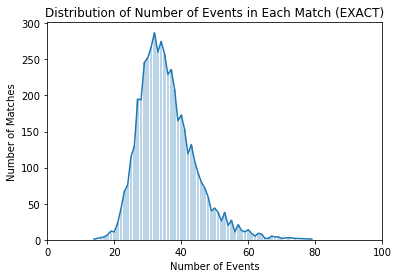

In [33]:
plt.bar(NumEventAnalysis2['EventNum'],NumEventAnalysis2['id'] ,alpha=0.3)
plt.plot(NumEventAnalysis2['EventNum'],NumEventAnalysis2['id'])
plt.title('Distribution of Number of Events in Each Match (EXACT)')
plt.xlim(0,100)
plt.xlabel("Number of Events")
plt.ylabel("Number of Matches")
plt.show()

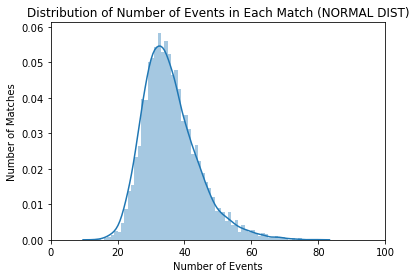

In [34]:
sns.distplot(NumEventAnalysis['EventNum'],bins=65)
plt.title('Distribution of Number of Events in Each Match (NORMAL DIST)')
plt.xlim(0,100)
plt.xlabel("Number of Events")
plt.ylabel("Number of Matches")
plt.show()

In [35]:
print("The max number of events for any team in a single game is:",NumEventAnalysis['EventNum'].max())
print("The min number of events for any team in a single game is:",NumEventAnalysis['EventNum'].min())

The max number of events for any team in a single game is: 79
The min number of events for any team in a single game is: 14


In [36]:
# We then create a table with just the unique match ids that we will use to merge our tables to shortly
matchevents = pd.DataFrame(stackedData['id'].unique())
matchevents.columns = ['id']

matchevents.head()

,id
0,0001f4374a03c133
1,0016710a48fdd46d
2,0016c9df37278448
3,0021b45647424cd5
4,00405293fb859241


In [37]:
# WARNING: Takes a while to run

# This cell has a lot of steps but the idea is to:
#    1) Seperate the the events into each team (Red/Blue)
#    2) For each, go through each match and transpose the list of events into a single row
#    3) Stack a table that has the events for both team of the matches

bluerows = pd.DataFrame()
stackedData_blue = stackedData
stackedData_blue['EventBlue'] = np.where( stackedData_blue['Team']!="Red",stackedData_blue['Event'],np.nan)


redrows = pd.DataFrame()
stackedData_red = stackedData
stackedData_red['EventRed'] = np.where( stackedData_red['Team']=="Red",stackedData_red['Event'],np.nan)


for i in range(0,len(matchevents)):
    
    #Red Team Output
    stackedData_match_red = stackedData_red[stackedData_red['id'] == matchevents.iloc[i,0] ]
    
    redextract = stackedData_match_red.iloc[:,[1,11]]
    redextract.iloc[:,0] = redextract.iloc[:,0]-1
    redextract = redextract.set_index('EventNum')
    
    redrow = pd.DataFrame(redextract.transpose())
    redrow['id'] = (stackedData_match_red['id'].unique())
    
    redrows = redrows.append((redrow))
    redrows = redrows.reset_index(drop=True)
    
    
    
    #Blue Team Output
    stackedData_match_blue = stackedData_blue[stackedData_blue['id'] == matchevents.iloc[i,0] ]
    
    blueextract = stackedData_match_blue.iloc[:,[1,10]]
    blueextract.iloc[:,0] = blueextract.iloc[:,0]-1
    blueextract = blueextract.set_index('EventNum')
    
    bluerow = pd.DataFrame(blueextract.transpose())
    bluerow['id'] = (stackedData_match_blue['id'].unique())
    
    bluerows = bluerows.append((bluerow))
    bluerows = bluerows.reset_index(drop=True)
    

In [38]:
redrows = redrows.sort_values('id')
redrows.head(5)

,0,1,2,3,4,5,6,7,8,9,...,69,70,71,72,73,74,75,76,77,78
0,KILLS,KILLS,NaN,KILLS,OUTER_TURRET,NaN,DRAGON,RIFT_HERALD,OUTER_TURRET,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,KILLS,DRAGON,KILLS,NaN,NaN,KILLS,NaN,NaN,KILLS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,KILLS,NaN,NaN,OUTER_TURRET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,KILLS,KILLS,KILLS,NaN,DRAGON,RIFT_HERALD,NaN,OUTER_TURRET,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,KILLS,NaN,NaN,NaN,NaN,OUTER_TURRET,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
bluerows = bluerows.sort_values('id')
bluerows.head(5)

,0,1,2,3,4,5,6,7,8,9,...,69,70,71,72,73,74,75,76,77,78
0,NaN,NaN,KILLS,NaN,NaN,OUTER_TURRET,NaN,NaN,NaN,OUTER_TURRET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,KILLS,NaN,NaN,NaN,KILLS,OUTER_TURRET,NaN,DRAGON,KILLS,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,KILLS,KILLS,KILLS,OUTER_TURRET,DRAGON,KILLS,NaN,KILLS,RIFT_HERALD,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,KILLS,NaN,NaN,NaN,KILLS,NaN,NaN,KILLS,NaN,KILLS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,KILLS,KILLS,KILLS,OUTER_TURRET,NaN,DRAGON,KILLS,OUTER_TURRET,KILLS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
# We can now merge these two tables for each team's events in the match to
# our table with just the match ids. We also add a column for the result of 
# the red team for the match and change column names according to which team 
# made the event.



matchevents2 = matchevents.merge(redrows,how='left',on='id')
matchevents3 = matchevents2.merge(bluerows,how='left',on='id')
    

    
matchevents4 = matchevents3.merge(matchinfo[['id','rResult','gamelength']], on='id',how='left')


matchevents4.columns = ['id',
'RedEvent1','RedEvent2','RedEvent3',
'RedEvent4','RedEvent5','RedEvent6','RedEvent7',
'RedEvent8','RedEvent9','RedEvent10','RedEvent11',
'RedEvent12','RedEvent13','RedEvent14','RedEvent15',
'RedEvent16','RedEvent17','RedEvent18','RedEvent19',
'RedEvent20','RedEvent21','RedEvent22','RedEvent23',
'RedEvent24','RedEvent25','RedEvent26','RedEvent27',
'RedEvent28','RedEvent29','RedEvent30','RedEvent31',
'RedEvent32','RedEvent33','RedEvent34','RedEvent35',
'RedEvent36','RedEvent37','RedEvent38','RedEvent39',
'RedEvent40','RedEvent41','RedEvent42','RedEvent43',
'RedEvent44','RedEvent45','RedEvent46','RedEvent47',
'RedEvent48','RedEvent49','RedEvent50','RedEvent51',
'RedEvent52','RedEvent53','RedEvent54','RedEvent55',
'RedEvent56','RedEvent57','RedEvent58','RedEvent59',
'RedEvent60','RedEvent61','RedEvent62','RedEvent63',
'RedEvent64','RedEvent65','RedEvent66','RedEvent67',
'RedEvent68','RedEvent69','RedEvent70','RedEvent71',
'RedEvent72','RedEvent73','RedEvent74','RedEvent75',
'RedEvent76','RedEvent77','RedEvent78','RedEvent79',
                        
                        
'BlueEvent1','BlueEvent2','BlueEvent3','BlueEvent4',
'BlueEvent5','BlueEvent6','BlueEvent7','BlueEvent8',
'BlueEvent9','BlueEvent10','BlueEvent11','BlueEvent12',
'BlueEvent13','BlueEvent14','BlueEvent15','BlueEvent16',
'BlueEvent17','BlueEvent18','BlueEvent19','BlueEvent20',
'BlueEvent21','BlueEvent22','BlueEvent23','BlueEvent24',
'BlueEvent25','BlueEvent26','BlueEvent27','BlueEvent28',
'BlueEvent29','BlueEvent30','BlueEvent31','BlueEvent32',
'BlueEvent33','BlueEvent34','BlueEvent35','BlueEvent36',
'BlueEvent37','BlueEvent38','BlueEvent39','BlueEvent40',
'BlueEvent41','BlueEvent42','BlueEvent43','BlueEvent44',
'BlueEvent45','BlueEvent46','BlueEvent47','BlueEvent48',
'BlueEvent49','BlueEvent50','BlueEvent51','BlueEvent52',
'BlueEvent53','BlueEvent54','BlueEvent55','BlueEvent56',
'BlueEvent57','BlueEvent58','BlueEvent59','BlueEvent60',
'BlueEvent61','BlueEvent62','BlueEvent63',
'BlueEvent64','BlueEvent65','BlueEvent66','BlueEvent67',
'BlueEvent68','BlueEvent69','BlueEvent70','BlueEvent71',
'BlueEvent72','BlueEvent73','BlueEvent74','BlueEvent75',
'BlueEvent76','BlueEvent77','BlueEvent78','BlueEvent79',
                        
                        'rResult','gamelength']



matchevents4.head(20)

,id,RedEvent1,RedEvent2,RedEvent3,RedEvent4,RedEvent5,RedEvent6,RedEvent7,RedEvent8,RedEvent9,...,BlueEvent72,BlueEvent73,BlueEvent74,BlueEvent75,BlueEvent76,BlueEvent77,BlueEvent78,BlueEvent79,rResult,gamelength
0,0001f4374a03c133,KILLS,KILLS,NaN,KILLS,OUTER_TURRET,NaN,DRAGON,RIFT_HERALD,OUTER_TURRET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,34
1,0016710a48fdd46d,NaN,KILLS,DRAGON,KILLS,NaN,NaN,KILLS,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,40
2,0016c9df37278448,NaN,NaN,NaN,NaN,NaN,NaN,KILLS,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,40
3,0021b45647424cd5,NaN,KILLS,KILLS,KILLS,NaN,DRAGON,RIFT_HERALD,NaN,OUTER_TURRET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,42
4,00405293fb859241,KILLS,NaN,NaN,NaN,NaN,OUTER_TURRET,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,39
5,00416ed438e29f14,NaN,KILLS,NaN,NaN,NaN,OUTER_TURRET,NaN,KILLS,KILLS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,41
6,007802c051352561,NaN,KILLS,DRAGON,KILLS,KILLS,RIFT_HERALD,NaN,NaN,OUTER_TURRET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,44
7,0091705b03924485,NaN,NaN,NaN,NaN,NaN,NaN,DRAGON,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,27
8,00986b51908a63c3,NaN,KILLS,KILLS,KILLS,KILLS,KILLS,NaN,OUTER_TURRET,DRAGON,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,69
9,00b13dbf1bd7aff0,NaN,KILLS,OUTER_TURRET,NaN,DRAGON,NaN,DRAGON,OUTER_TURRET,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,36


In [41]:
# We now decided, for the purpose of calculating probabilities, to consider one team's perseperctive.
# Therefore, we make all events either positive or negative for red team but keep their label otherwise.

matchevents5=matchevents4
for j in range(1,len(list(redrows))):
    matchevents5['RedEvent'+str(j)] = '+'+ matchevents5['RedEvent'+str(j)].astype(str)
    matchevents5['BlueEvent'+str(j)] = '-'+ matchevents5['BlueEvent'+str(j)].astype(str)
    
    matchevents5 = matchevents5.replace('+nan',np.nan)
    matchevents5['RedEvent'+str(j)] =  matchevents5['RedEvent'+str(j)].fillna(
                                        (matchevents5['BlueEvent'+str(j)]).astype(str))
    
matchevents5.head()

,id,RedEvent1,RedEvent2,RedEvent3,RedEvent4,RedEvent5,RedEvent6,RedEvent7,RedEvent8,RedEvent9,...,BlueEvent72,BlueEvent73,BlueEvent74,BlueEvent75,BlueEvent76,BlueEvent77,BlueEvent78,BlueEvent79,rResult,gamelength
0,0001f4374a03c133,+KILLS,+KILLS,-KILLS,+KILLS,+OUTER_TURRET,-OUTER_TURRET,+DRAGON,+RIFT_HERALD,+OUTER_TURRET,...,-nan,-nan,-nan,-nan,-nan,-nan,-nan,-nan,1,34
1,0016710a48fdd46d,-KILLS,+KILLS,+DRAGON,+KILLS,-KILLS,-OUTER_TURRET,+KILLS,-DRAGON,-KILLS,...,-nan,-nan,-nan,-nan,-nan,-nan,-nan,-nan,1,40
2,0016c9df37278448,-KILLS,-KILLS,-KILLS,-OUTER_TURRET,-DRAGON,-KILLS,+KILLS,-KILLS,-RIFT_HERALD,...,-nan,-nan,-nan,-nan,-nan,-nan,-nan,-nan,1,40
3,0021b45647424cd5,-KILLS,+KILLS,+KILLS,+KILLS,-KILLS,+DRAGON,+RIFT_HERALD,-KILLS,+OUTER_TURRET,...,-nan,-nan,-nan,-nan,-nan,-nan,-nan,-nan,1,42
4,00405293fb859241,+KILLS,-KILLS,-KILLS,-KILLS,-OUTER_TURRET,+OUTER_TURRET,-DRAGON,-KILLS,-OUTER_TURRET,...,-nan,-nan,-nan,-nan,-nan,-nan,-nan,-nan,1,39


In [42]:
# We take on the red event columns now  and re-add the end result of the game for red team (1=win, 0=loss)

RedMatchEvents = matchevents5.iloc[:,0:80]
RedMatchEvents['RedResult'] = matchevents5['rResult']
RedMatchEvents['MatchLength'] = matchevents5['gamelength']
RedMatchEvents.iloc[0:10]

,id,RedEvent1,RedEvent2,RedEvent3,RedEvent4,RedEvent5,RedEvent6,RedEvent7,RedEvent8,RedEvent9,...,RedEvent72,RedEvent73,RedEvent74,RedEvent75,RedEvent76,RedEvent77,RedEvent78,RedEvent79,RedResult,MatchLength
0,0001f4374a03c133,+KILLS,+KILLS,-KILLS,+KILLS,+OUTER_TURRET,-OUTER_TURRET,+DRAGON,+RIFT_HERALD,+OUTER_TURRET,...,-nan,-nan,-nan,-nan,-nan,-nan,-nan,-nan,1,34
1,0016710a48fdd46d,-KILLS,+KILLS,+DRAGON,+KILLS,-KILLS,-OUTER_TURRET,+KILLS,-DRAGON,-KILLS,...,-nan,-nan,-nan,-nan,-nan,-nan,-nan,-nan,1,40
2,0016c9df37278448,-KILLS,-KILLS,-KILLS,-OUTER_TURRET,-DRAGON,-KILLS,+KILLS,-KILLS,-RIFT_HERALD,...,-nan,-nan,-nan,-nan,-nan,-nan,-nan,-nan,1,40
3,0021b45647424cd5,-KILLS,+KILLS,+KILLS,+KILLS,-KILLS,+DRAGON,+RIFT_HERALD,-KILLS,+OUTER_TURRET,...,-nan,-nan,-nan,-nan,-nan,-nan,-nan,-nan,1,42
4,00405293fb859241,+KILLS,-KILLS,-KILLS,-KILLS,-OUTER_TURRET,+OUTER_TURRET,-DRAGON,-KILLS,-OUTER_TURRET,...,-nan,-nan,-nan,-nan,-nan,-nan,-nan,-nan,1,39
5,00416ed438e29f14,-KILLS,+KILLS,-KILLS,-DRAGON,-KILLS,+OUTER_TURRET,-KILLS,+KILLS,+KILLS,...,-nan,-nan,-nan,-nan,-nan,-nan,-nan,-nan,1,41
6,007802c051352561,-KILLS,+KILLS,+DRAGON,+KILLS,+KILLS,+RIFT_HERALD,-OUTER_TURRET,-OUTER_TURRET,+OUTER_TURRET,...,-nan,-nan,-nan,-nan,-nan,-nan,-nan,-nan,1,44
7,0091705b03924485,-KILLS,-KILLS,-OUTER_TURRET,-KILLS,-KILLS,-OUTER_TURRET,+DRAGON,-RIFT_HERALD,-OUTER_TURRET,...,-nan,-nan,-nan,-nan,-nan,-nan,-nan,-nan,0,27
8,00986b51908a63c3,-KILLS,+KILLS,+KILLS,+KILLS,+KILLS,+KILLS,-OUTER_TURRET,+OUTER_TURRET,+DRAGON,...,-nan,-nan,-nan,-nan,-nan,-nan,-nan,-nan,0,69
9,00b13dbf1bd7aff0,-KILLS,+KILLS,+OUTER_TURRET,-OUTER_TURRET,+DRAGON,-KILLS,+DRAGON,+OUTER_TURRET,-OUTER_TURRET,...,-nan,-nan,-nan,-nan,-nan,-nan,-nan,-nan,0,36


In [43]:
RedMatchEvents[['RedEvent1','id']].groupby('RedEvent1').count()


,id
RedEvent1,
+DRAGON,158
+KILLS,1931
+OUTER_TURRET,263
+RIFT_HERALD,7
-DRAGON,108
-KILLS,2136
-OUTER_TURRET,302
-RIFT_HERALD,10


In [44]:
RedMatchEvents[['RedEvent1','MatchLength']].groupby('RedEvent1').mean()


,MatchLength
RedEvent1,
+DRAGON,38.278481
+KILLS,36.599689
+OUTER_TURRET,37.680608
+RIFT_HERALD,39.428571
-DRAGON,37.750000
-KILLS,36.265918
-OUTER_TURRET,38.049669
-RIFT_HERALD,41.500000


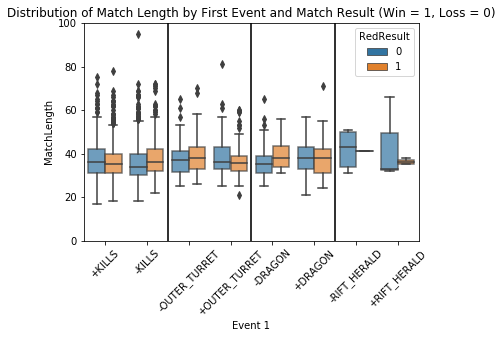

In [45]:
sns.boxplot(RedMatchEvents['RedEvent1'],RedMatchEvents['MatchLength'],RedMatchEvents['RedResult'],
            boxprops=dict(alpha=.7) )
plt.xticks(rotation=45)
plt.title('Distribution of Match Length by First Event and Match Result (Win = 1, Loss = 0)')
plt.ylim(0,100)
plt.xlabel('Event 1')
plt.plot([1.5, 1.5], [0, 100],'k', linewidth=2,alpha=0.8 )
plt.plot([3.5, 3.5], [0, 100],'k', linewidth=2,alpha=0.8 )
plt.plot([5.5, 5.5], [0, 100],'k', linewidth=2,alpha=0.8 )
plt.show()

In [46]:
# We can now use this to calculate some conditional probabilities as shown

TestData = RedMatchEvents

PwinGivenFirstBloodWon = ( (len(TestData[(TestData['RedEvent1']=="+KILLS")&(TestData['RedResult']==1)])/len(TestData))/
        (len( TestData[TestData['RedEvent1']=="+KILLS"])/len(TestData)) )
    
PwinGivenFirstBloodLost = ( (len(TestData[(TestData['RedEvent1']=="-KILLS")&(TestData['RedResult']==1)])/len(TestData))/
        (len( TestData[TestData['RedEvent1']=="-KILLS"])/len(TestData)) )


PwinGivenFirstTowerWon = ( (len(TestData[(TestData['RedEvent1']=="+OUTER_TURRET")&(TestData['RedResult']==1)])/len(TestData))/
        (len( TestData[TestData['RedEvent1']=="+OUTER_TURRET"])/len(TestData)) )
    
PwinGivenFirstTowerLost = ( (len(TestData[(TestData['RedEvent1']=="-OUTER_TURRET")&(TestData['RedResult']==1)])/len(TestData))/
        (len( TestData[TestData['RedEvent1']=="-OUTER_TURRET"])/len(TestData)) )


PwinGivenFirstDragonWon = ( (len(TestData[(TestData['RedEvent1']=="+DRAGON")&(TestData['RedResult']==1)])/len(TestData))/
        (len( TestData[TestData['RedEvent1']=="+DRAGON"])/len(TestData)) )
    
PwinGivenFirstDragonLost = ( (len(TestData[(TestData['RedEvent1']=="-DRAGON")&(TestData['RedResult']==1)])/len(TestData))/
        (len( TestData[TestData['RedEvent1']=="-DRAGON"])/len(TestData)) )


PwinGivenFirstRiftHeraldWon = ( (len(TestData[(TestData['RedEvent1']=="+RIFT_HERALD")&(TestData['RedResult']==1)])/len(TestData))/
        (len( TestData[TestData['RedEvent1']=="+RIFT_HERALD"])/len(TestData)) )
    
PwinGivenFirstRiftHeraldLost = ( (len(TestData[(TestData['RedEvent1']=="-RIFT_HERALD")&(TestData['RedResult']==1)])/len(TestData))/
        (len( TestData[TestData['RedEvent1']=="-RIFT_HERALD"])/len(TestData)) )





print("-------FIRST BLOOD--------------------------------")
print("P(Won | First Blood Taken):",PwinGivenFirstBloodWon)
print("P(Won | First Blood Lost):",PwinGivenFirstBloodLost)

print("")
print("-------FIRST TURRET-------------------------------")
print("P(Won | First Tower Won):",PwinGivenFirstTowerWon)
print("P(Won | First Tower Lost):",PwinGivenFirstTowerLost)

print("")
print("-------FIRST DRAGON-------------------------------")
print("P(Won | First Dragon Won):",PwinGivenFirstDragonWon)
print("P(Won | First Dragon Lost):",PwinGivenFirstDragonLost)

print("")
print("-------FIRST RIFT HERALD (NOTE: ONLY 17 GAMES)----")
print("P(Won | First Rift Herald Won):",PwinGivenFirstRiftHeraldWon)
print("P(Won | First Rift Herald Lost):",PwinGivenFirstRiftHeraldLost)

-------FIRST BLOOD--------------------------------
P(Won | First Blood Taken): 0.5535991714137752
P(Won | First Blood Lost): 0.3647003745318352

-------FIRST TURRET-------------------------------
P(Won | First Tower Won): 0.4790874524714828
P(Won | First Tower Lost): 0.4470198675496689

-------FIRST DRAGON-------------------------------
P(Won | First Dragon Won): 0.5189873417721519
P(Won | First Dragon Lost): 0.4351851851851851

-------FIRST RIFT HERALD (NOTE: ONLY 17 GAMES)----
P(Won | First Rift Herald Won): 0.5714285714285714
P(Won | First Rift Herald Lost): 0.1


In [47]:
aggs = {'id':'count','MatchLength':'mean'}

RedMatchTWOEvents = (RedMatchEvents[['RedEvent1','RedEvent2','RedResult','id','MatchLength']].groupby(
        ['RedEvent1','RedEvent2','RedResult']).agg(aggs).reset_index())

RedMatchTWOEvents = RedMatchTWOEvents.sort_values(['RedEvent1','RedEvent2','RedResult'])

RedMatchTWOEventsWINS = RedMatchTWOEvents[RedMatchTWOEvents['RedResult']==1]
RedMatchTWOEventsLOSS = RedMatchTWOEvents[RedMatchTWOEvents['RedResult']==0]

In [49]:
# First merge the RedWin and RedLoss data tables
# Then remove events which only resulted in a win then calculate the total number of games that has these two events
# Use this total to calculate the prob of win and loss respectively 

RedMatchTWOEventsMERGED = RedMatchTWOEventsWINS.merge(RedMatchTWOEventsLOSS, how='left',on=['RedEvent1','RedEvent2'])


RedMatchTWOEventsMERGED = RedMatchTWOEventsMERGED[RedMatchTWOEventsMERGED['id_y']>0]
RedMatchTWOEventsMERGED['Total'] = RedMatchTWOEventsMERGED['id_x']+RedMatchTWOEventsMERGED['id_y']

RedMatchTWOEventsMERGED['ProbWIN'] = RedMatchTWOEventsMERGED['id_x']/RedMatchTWOEventsMERGED['Total'].sum()
RedMatchTWOEventsMERGED['ProbLOSS'] = RedMatchTWOEventsMERGED['id_y']/RedMatchTWOEventsMERGED['Total'].sum()

RedMatchTWOEventsMERGED['ProbE1ANDE2'] = RedMatchTWOEventsMERGED['Total']/(RedMatchTWOEventsMERGED['Total'].sum())

RedMatchTWOEventsMERGED['ProbWINgivenE1ANDE2'] = RedMatchTWOEventsMERGED['ProbWIN']/RedMatchTWOEventsMERGED['ProbE1ANDE2']
RedMatchTWOEventsMERGED['ProbLOSSgivenE1ANDE2'] = RedMatchTWOEventsMERGED['ProbLOSS']/RedMatchTWOEventsMERGED['ProbE1ANDE2']

# Create column to single binary digit for whether the first event is positive or negative

RedMatchTWOEventsMERGED['RedEvent1Gain'] = np.where(
                                (RedMatchTWOEventsMERGED['RedEvent1']=="+KILLS") |
                                (RedMatchTWOEventsMERGED['RedEvent1']=="+OUTER_TURRET") |
                                (RedMatchTWOEventsMERGED['RedEvent1']=="+DRAGON") |
                                (RedMatchTWOEventsMERGED['RedEvent1']=="+RIFT_HERALD") ,1,0
                                                   
                                                   
                                                   )
# Repeat for second event

RedMatchTWOEventsMERGED['RedEvent2Gain'] = np.where(
                                (RedMatchTWOEventsMERGED['RedEvent2']=="+KILLS") |
                                (RedMatchTWOEventsMERGED['RedEvent2']=="+OUTER_TURRET") |
                                (RedMatchTWOEventsMERGED['RedEvent2']=="+DRAGON") |
                                (RedMatchTWOEventsMERGED['RedEvent2']=="+RIFT_HERALD") ,1,0
                                                   
                                                   
                                                   )
# Create another column for combination of first and second event outcomes classification
RedMatchTWOEventsMERGED['Event1AND2Outcome'] = np.where(
    (RedMatchTWOEventsMERGED['RedEvent1Gain']==1)&(RedMatchTWOEventsMERGED['RedEvent2Gain']==1),"Both Positive",
                
    np.where(
        (((RedMatchTWOEventsMERGED['RedEvent1Gain']==1)&(RedMatchTWOEventsMERGED['RedEvent2Gain']==0))|
        ((RedMatchTWOEventsMERGED['RedEvent1Gain']==0)&(RedMatchTWOEventsMERGED['RedEvent2Gain']==1))),"One Positive",
    
    np.where(
        (RedMatchTWOEventsMERGED['RedEvent1Gain']==0)&(RedMatchTWOEventsMERGED['RedEvent2Gain']==0),"Neither Positive",
             "MISSING",)))

# Sort by highest probability of win to lowest
RedMatchTWOEventsMERGED = RedMatchTWOEventsMERGED.sort_values('ProbWINgivenE1ANDE2',ascending=False)

# Remove event combination with less than x number of games to remove possible outliers
RedMatchTWOEventsMERGED = RedMatchTWOEventsMERGED[RedMatchTWOEventsMERGED['Total']>=0]


RedMatchTWOEventsMERGED.head(5)

,RedEvent1,RedEvent2,RedResult_x,MatchLength_x,id_x,RedResult_y,MatchLength_y,id_y,Total,ProbWIN,ProbLOSS,ProbE1ANDE2,ProbWINgivenE1ANDE2,ProbLOSSgivenE1ANDE2,RedEvent1Gain,RedEvent2Gain,Event1AND2Outcome
16,+OUTER_TURRET,+KILLS,1,38.181818,11,0.0,34.50,2.0,13.0,0.002248,0.000409,0.002656,0.846154,0.153846,1,1,Both Positive
9,+KILLS,+RIFT_HERALD,1,31.750000,4,0.0,33.00,1.0,5.0,0.000817,0.000204,0.001022,0.800000,0.200000,1,1,Both Positive
1,+DRAGON,+OUTER_TURRET,1,37.636364,11,0.0,41.75,4.0,15.0,0.002248,0.000817,0.003065,0.733333,0.266667,1,1,Both Positive
21,+RIFT_HERALD,-DRAGON,1,36.500000,2,0.0,32.00,1.0,3.0,0.000409,0.000204,0.000613,0.666667,0.333333,1,0,One Positive
20,+RIFT_HERALD,+KILLS,1,36.000000,2,0.0,33.00,1.0,3.0,0.000409,0.000204,0.000613,0.666667,0.333333,1,1,Both Positive


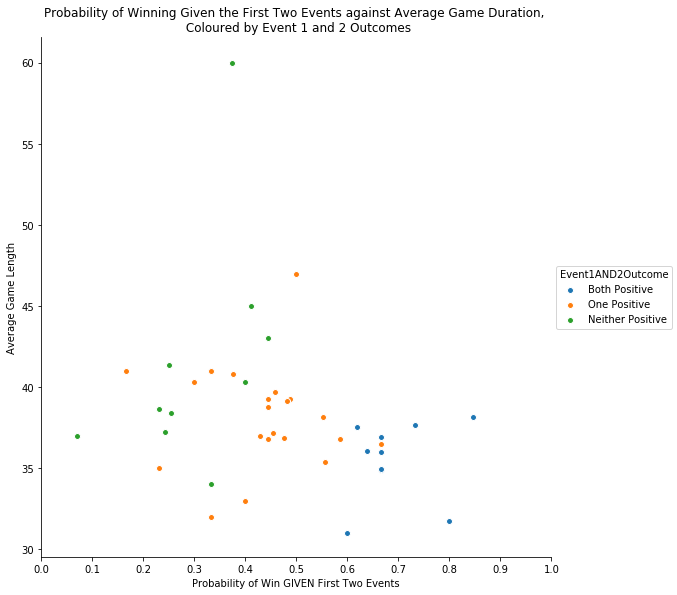

In [50]:
sns.pairplot(data = RedMatchTWOEventsMERGED, x_vars='ProbWINgivenE1ANDE2',y_vars='MatchLength_x',
           hue= 'Event1AND2Outcome', size=8)
plt.title('Probability of Winning Given the First Two Events against Average Game Duration, \n Coloured by Event 1 and 2 Outcomes')
plt.xlabel('Probability of Win GIVEN First Two Events')
plt.ylabel('Average Game Length')
plt.xlim([0,1])
plt.xticks(np.arange(0,1.1,0.1))
#plt.ylim([20,50])

plt.show()

In [51]:
RedMatchEvents.head()


,id,RedEvent1,RedEvent2,RedEvent3,RedEvent4,RedEvent5,RedEvent6,RedEvent7,RedEvent8,RedEvent9,...,RedEvent72,RedEvent73,RedEvent74,RedEvent75,RedEvent76,RedEvent77,RedEvent78,RedEvent79,RedResult,MatchLength
0,0001f4374a03c133,+KILLS,+KILLS,-KILLS,+KILLS,+OUTER_TURRET,-OUTER_TURRET,+DRAGON,+RIFT_HERALD,+OUTER_TURRET,...,-nan,-nan,-nan,-nan,-nan,-nan,-nan,-nan,1,34
1,0016710a48fdd46d,-KILLS,+KILLS,+DRAGON,+KILLS,-KILLS,-OUTER_TURRET,+KILLS,-DRAGON,-KILLS,...,-nan,-nan,-nan,-nan,-nan,-nan,-nan,-nan,1,40
2,0016c9df37278448,-KILLS,-KILLS,-KILLS,-OUTER_TURRET,-DRAGON,-KILLS,+KILLS,-KILLS,-RIFT_HERALD,...,-nan,-nan,-nan,-nan,-nan,-nan,-nan,-nan,1,40
3,0021b45647424cd5,-KILLS,+KILLS,+KILLS,+KILLS,-KILLS,+DRAGON,+RIFT_HERALD,-KILLS,+OUTER_TURRET,...,-nan,-nan,-nan,-nan,-nan,-nan,-nan,-nan,1,42
4,00405293fb859241,+KILLS,-KILLS,-KILLS,-KILLS,-OUTER_TURRET,+OUTER_TURRET,-DRAGON,-KILLS,-OUTER_TURRET,...,-nan,-nan,-nan,-nan,-nan,-nan,-nan,-nan,1,39


In [52]:
# WARNING: Takes a while to run
# Replace all N/As with the match outcome so that our final state is either a Win or Loss
for i in range(1,80):
    RedMatchEvents['RedEvent'+str(i)] = RedMatchEvents['RedEvent'+str(i)].replace('-nan',RedMatchEvents['RedResult'].astype(str))
    RedMatchEvents['RedEvent'+str(i)] = RedMatchEvents['RedEvent'+str(i)].replace('+nan',RedMatchEvents['RedResult'].astype(str))
    #Print i for progress tracking
    #print(i)
RedMatchEvents.head()

,id,RedEvent1,RedEvent2,RedEvent3,RedEvent4,RedEvent5,RedEvent6,RedEvent7,RedEvent8,RedEvent9,...,RedEvent72,RedEvent73,RedEvent74,RedEvent75,RedEvent76,RedEvent77,RedEvent78,RedEvent79,RedResult,MatchLength
0,0001f4374a03c133,+KILLS,+KILLS,-KILLS,+KILLS,+OUTER_TURRET,-OUTER_TURRET,+DRAGON,+RIFT_HERALD,+OUTER_TURRET,...,1,1,1,1,1,1,1,1,1,34
1,0016710a48fdd46d,-KILLS,+KILLS,+DRAGON,+KILLS,-KILLS,-OUTER_TURRET,+KILLS,-DRAGON,-KILLS,...,1,1,1,1,1,1,1,1,1,40
2,0016c9df37278448,-KILLS,-KILLS,-KILLS,-OUTER_TURRET,-DRAGON,-KILLS,+KILLS,-KILLS,-RIFT_HERALD,...,1,1,1,1,1,1,1,1,1,40
3,0021b45647424cd5,-KILLS,+KILLS,+KILLS,+KILLS,-KILLS,+DRAGON,+RIFT_HERALD,-KILLS,+OUTER_TURRET,...,1,1,1,1,1,1,1,1,1,42
4,00405293fb859241,+KILLS,-KILLS,-KILLS,-KILLS,-OUTER_TURRET,+OUTER_TURRET,-DRAGON,-KILLS,-OUTER_TURRET,...,1,1,1,1,1,1,1,1,1,39


In [53]:
RedMatchEvents[['RedEvent60','id']].groupby('RedEvent60').count()


,id
RedEvent60,
+BARON_NASHOR,4
+BASE_TURRET,2
+ELDER_DRAGON,1
+INHIBITOR,12
+INNER_TURRET,2
+KILLS,7
+NEXUS_TURRET,5
-BARON_NASHOR,1
-BASE_TURRET,3


In [54]:
RedMatchEvents2 = RedMatchEvents


In [62]:
# WARNING: Takes a little while to run
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1' # 指定第二块gpu

EventList = [
    #Positive Events
       '+KILLS', '+OUTER_TURRET', '+DRAGON', '+RIFT_HERALD', '+BARON_NASHOR',
       '+INNER_TURRET', '+BASE_TURRET', '+INHIBITOR', '+NEXUS_TURRET',
       '+ELDER_DRAGON',
    #Negative Events
       '-KILLS', '-OUTER_TURRET', '-DRAGON', '-RIFT_HERALD', '-BARON_NASHOR',
       '-INNER_TURRET', '-BASE_TURRET', '-INHIBITOR', '-NEXUS_TURRET',
       '-ELDER_DRAGON',
    #Game Win or Loss Events        
       '1','0']

RedMatchMDP = pd.DataFrame()

for i in range(1,79):
                              
    Event = i
    for j1 in range(0,len(EventList)):
        Event1 = EventList[j1]
        for j2 in range(0,len(EventList)):
            
            Event2 = EventList[j2]
            
            
            if  len(RedMatchEvents2[(RedMatchEvents2['RedEvent'+str(Event)]==Event1)])==0:
                continue
            #elif len(RedMatchEvents2[(RedMatchEvents2['RedEvent'+str(Event)]==Event1)&
            #                   (RedMatchEvents2['RedEvent'+str(Event+1)]==Event2) ])==0:
                continue
                
            else:
                TransProb = (
                    len(RedMatchEvents2[(RedMatchEvents2['RedEvent'+str(Event)]==Event1)&
                               (RedMatchEvents2['RedEvent'+str(Event+1)]==Event2) ])/

                    len(RedMatchEvents2[(RedMatchEvents2['RedEvent'+str(Event)]==Event1)])
                    )


            RedMatchMDP2 = pd.DataFrame({'StartState':Event,'EndState':Event+1,'Event1':Event1,'Event2':Event2,'Probability':TransProb},
                                  index=[0])
            RedMatchMDP = RedMatchMDP.append(RedMatchMDP2)
   
    #Print i for tracking progress
    #print(i)

In [63]:
RedMatchMDP = RedMatchMDP[['StartState','EndState','Event1','Event2','Probability']]
RedMatchMDP[(RedMatchMDP['StartState']==61)&(RedMatchMDP['Event1']=="+INHIBITOR")]

,StartState,EndState,Event1,Event2,Probability
0,61,62,+INHIBITOR,+KILLS,0.076923
0,61,62,+INHIBITOR,+OUTER_TURRET,0.000000
0,61,62,+INHIBITOR,+DRAGON,0.000000
0,61,62,+INHIBITOR,+RIFT_HERALD,0.000000
0,61,62,+INHIBITOR,+BARON_NASHOR,0.153846
0,61,62,+INHIBITOR,+INNER_TURRET,0.076923
0,61,62,+INHIBITOR,+BASE_TURRET,0.000000
0,61,62,+INHIBITOR,+INHIBITOR,0.076923
0,61,62,+INHIBITOR,+NEXUS_TURRET,0.153846
0,61,62,+INHIBITOR,+ELDER_DRAGON,0.000000


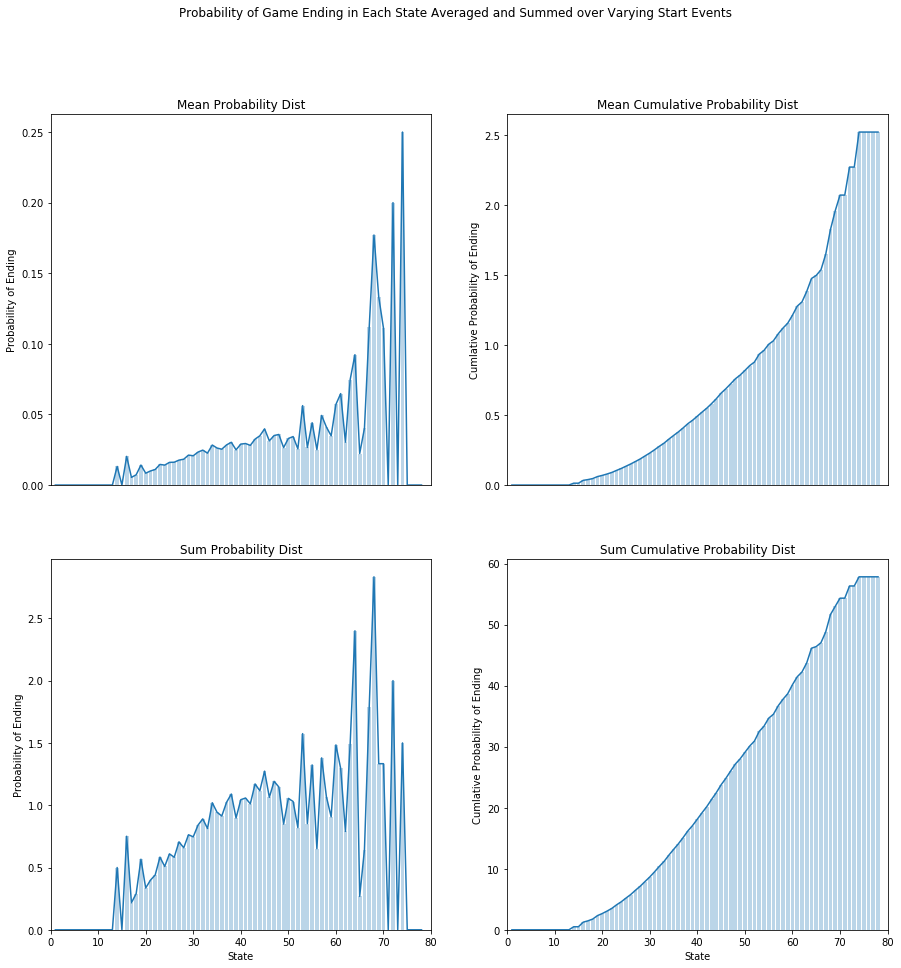

In [64]:
EndCondition = RedMatchMDP[
    ((RedMatchMDP['Event1']!="1")&(RedMatchMDP['Event2']=="1") )|
    ((RedMatchMDP['Event1']!="0")&(RedMatchMDP['Event2']=="0"))]

EndCondition = EndCondition.sort_values('Probability',ascending=False)

EndConditionGrouped = EndCondition[['StartState','Probability']].groupby('StartState').mean().reset_index()
EndConditionGrouped['CumProb'] = EndConditionGrouped['Probability'].cumsum()

EndConditionGrouped2 = EndCondition[['StartState','Probability']].groupby('StartState').sum().reset_index()
EndConditionGrouped2['CumProb'] = EndConditionGrouped2['Probability'].cumsum()

fig, axes = plt.subplots(nrows=2, ncols=2)

axes[0,0].bar(EndConditionGrouped['StartState'],EndConditionGrouped['Probability'] ,alpha=0.3)
axes[0,0].plot(EndConditionGrouped['StartState'],EndConditionGrouped['Probability'])
axes[0,0].set_title('Mean Probability Dist')
axes[0,0].set_xlabel("State")
axes[0,0].set_ylabel("Probability of Ending")
axes[0,0].set_xticks([],[])
axes[0,0].set_xlabel("")
axes[0,0].set_xlim([0,80])
axes[0,0].grid(False)

axes[0,1].bar(EndConditionGrouped['StartState'],EndConditionGrouped['CumProb'] ,alpha=0.3)
axes[0,1].plot(EndConditionGrouped['StartState'],EndConditionGrouped['CumProb'])
axes[0,1].set_title('Mean Cumulative Probability Dist')
axes[0,1].set_xlabel("State")
axes[0,1].set_ylabel("Cumlative Probability of Ending")
axes[0,1].set_xticks([])
axes[0,1].set_xlabel("")
axes[0,1].set_xlim([0,80])
axes[0,1].grid(False)

axes[1,0].bar(EndConditionGrouped2['StartState'],EndConditionGrouped2['Probability'] ,alpha=0.3)
axes[1,0].plot(EndConditionGrouped2['StartState'],EndConditionGrouped2['Probability'])
axes[1,0].set_title('Sum Probability Dist')
axes[1,0].set_xlabel("State")
axes[1,0].set_ylabel("Probability of Ending")
axes[1,0].set_xlim([0,80])
axes[1,0].grid(False)

axes[1,1].bar(EndConditionGrouped2['StartState'],EndConditionGrouped2['CumProb'] ,alpha=0.3)
axes[1,1].plot(EndConditionGrouped2['StartState'],EndConditionGrouped2['CumProb'])
axes[1,1].set_title('Sum Cumulative Probability Dist')
axes[1,1].set_xlabel("State")
axes[1,1].set_ylabel("Cumlative Probability of Ending")
axes[1,1].set_xlim([0,80])
axes[1,1].grid(False)

fig.suptitle("Probability of Game Ending in Each State Averaged and Summed over Varying Start Events")

fig.set_figheight(15)
fig.set_figwidth(15)
plt.show()

In [65]:
RedMatchMDP['Reward'] = 0

RedMatchMDP.head()

,StartState,EndState,Event1,Event2,Probability,Reward
0,1,2,+KILLS,+KILLS,0.350596,0
0,1,2,+KILLS,+OUTER_TURRET,0.058519,0
0,1,2,+KILLS,+DRAGON,0.076126,0
0,1,2,+KILLS,+RIFT_HERALD,0.002589,0
0,1,2,+KILLS,+BARON_NASHOR,0.000000,0


In [66]:
len(RedMatchMDP)


25564

In [67]:
RedMatchMDP[(RedMatchMDP['StartState']==15)&(RedMatchMDP['Event1']=="+ELDER_DRAGON")]


,StartState,EndState,Event1,Event2,Probability,Reward
0,15,16,+ELDER_DRAGON,+KILLS,0.5,0
0,15,16,+ELDER_DRAGON,+OUTER_TURRET,0.0,0
0,15,16,+ELDER_DRAGON,+DRAGON,0.0,0
0,15,16,+ELDER_DRAGON,+RIFT_HERALD,0.0,0
0,15,16,+ELDER_DRAGON,+BARON_NASHOR,0.0,0
0,15,16,+ELDER_DRAGON,+INNER_TURRET,0.0,0
0,15,16,+ELDER_DRAGON,+BASE_TURRET,0.0,0
0,15,16,+ELDER_DRAGON,+INHIBITOR,0.0,0
0,15,16,+ELDER_DRAGON,+NEXUS_TURRET,0.0,0
0,15,16,+ELDER_DRAGON,+ELDER_DRAGON,0.0,0


In [68]:
alpha = 0.1
gamma = 0.9
num_episodes = 100
epsilon = 0.1

reward = RedMatchMDP['Reward']

StartState = 1
StartEvent = '+KILLS'
StartAction = '+OUTER_TURRET'

In [70]:
def MCModelv1(data, alpha, gamma, epsilon, reward, StartState, StartEvent, StartAction, num_episodes):
    
    # Initiatise variables appropiately
    
    data['V'] = 0
 
    
    outcomes = pd.DataFrame()
    episode_return = pd.DataFrame()
    actions_output = pd.DataFrame()
    
    for e in range(0,num_episodes):
        
        action = []

        current_state = StartState
        current_action = StartEvent
        next_action = StartAction 
   
        actions = pd.DataFrame()
 
        for a in range(0,100):
            
            action_table = pd.DataFrame()

            
            if (current_action=="1") | (current_action=="0") | (current_state==79):
                continue
            else:
                
                data_e = data[(data['StartState']==current_state)&(data['Event1']==current_action)]

                data_e = data_e.sort_values('Probability')
                data_e['CumProb'] = data_e['Probability'].cumsum()
                data_e['CumProb'] = np.round(data_e['CumProb'],4)

                
                rng = np.round(np.random.random()*data_e['CumProb'].max(),4)
                action_table = data_e[ data_e['CumProb'] >= rng]
                action_table = action_table[ action_table['CumProb'] == action_table['CumProb'].min()]
                action_table = action_table.reset_index()
                
                action = action_table['Event2'][0]
                
                if action == "1":
                    step_reward = 10*(gamma**a)
                elif action == "0":
                    step_reward = -10*(gamma**a)
                else:
                    step_reward = -0.005*(gamma**a)
                
                action_table['StepReward'] = step_reward
                

                action_table['Episode'] = e
                action_table['Action'] = a
                
                current_action = action
                current_state = current_state+1
                
                
                actions = actions.append(action_table)

        actions_output = actions_output.append(actions)
                
        episode_return = actions['StepReward'].sum()

                
        actions['Return']= episode_return
                
        data = data.merge(actions[['StartState','EndState','Event1','Event2','Return']], how='left',on =['StartState','EndState','Event1','Event2'])
        data['Return'] = data['Return'].fillna(0)    
             
        data['V'] = data['V'] + alpha*(data['Return']-data['V'])
        data = data.drop('Return', 1)
        
        
                
        if current_action=="1":
            outcome = "WIN"
        elif current_action=="0":
            outcome = "LOSS"
        else:
            outcome = "INCOMPLETE"
        outcome = pd.DataFrame({'Epsiode':[e],'Outcome':[outcome]})
        outcomes = outcomes.append(outcome)

        
        

        
   
        
    
        
    optimal_policy_table = data[ ( data['StartState']==StartState) & (data['Event1']==StartEvent)&(data['Event2']==StartAction)]
     
    for i in range(2,79):
        optimal_V = data[data['StartState']==i]['V'].max()
        optimal_policy = data[ ( data['V']==optimal_V) & (data['StartState']==i)]      
        optimal_policy_table = optimal_policy_table.append(optimal_policy)
                
    return(outcomes,actions_output,data,optimal_policy_table)
    

In [71]:
start_time = timeit.default_timer()


Mdl = MCModelv1(data=RedMatchMDP, alpha = alpha, gamma=gamma, epsilon = epsilon, reward = reward,
                StartState=StartState, StartEvent=StartEvent,StartAction=StartAction,
                num_episodes = num_episodes)

elapsed = timeit.default_timer() - start_time

print("Time taken to run model:",np.round(elapsed/60,2),"mins")

Time taken to run model: 0.55 mins


In [72]:
Mdl[3].head()


,StartState,EndState,Event1,Event2,Probability,Reward,V
1,1,2,+KILLS,+OUTER_TURRET,0.058519,0,-0.000008
320,2,3,-OUTER_TURRET,-DRAGON,0.131356,0,0.003355
398,3,4,+KILLS,+DRAGON,0.091694,0,0.023447
660,4,5,+DRAGON,+KILLS,0.298942,0,0.020368
858,5,6,+KILLS,+KILLS,0.189329,0,0.030130
